In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
FOLDERNAME = "PUC_Rio/DL/Image_Captioning"
%cd drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/PUC_Rio/DL/Image_Captioning


In [3]:
# %ls

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00


In [8]:
import torch
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
from transformers import BertTokenizer
import torchvision.transforms as transforms

In [9]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ImageEncoder(nn.Module):
    def __init__(self, device, pretrained_model):
        super(ImageEncoder, self).__init__()

        self.device = device

        self.vit = ViTModel.from_pretrained(pretrained_model)

        for param in self.vit.parameters():
            param.requires_grad = False

        self.hidden_dim = self.vit.config.hidden_size

    def forward(self, imgs):

        imgs = imgs.to(self.device)

        encoded_imgs = self.vit(imgs)

        return encoded_imgs.last_hidden_state

In [10]:
import torch
import torch.nn as nn
from torch.nn import Transformer
from transformers import AutoModel, AutoConfig
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import torch.nn.functional as F


class ImageCaptionDecoder(nn.Module):
    def __init__(self, device, encoder_dim, decoder_dim, bert_model_name, d_model, nhead, num_layers, batch_size, n_vocab):
        super(ImageCaptionDecoder, self).__init__()

        self.device = device
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.d_model = d_model
        self.nhead = nhead
        self.batch_size = batch_size
        self.n_vocab = n_vocab


        # Load the pre-trained BERT model
        bert_config = AutoConfig.from_pretrained(bert_model_name)
        bert_config.output_hidden_states = True
        self.bert = AutoModel.from_pretrained(bert_model_name, config=bert_config)

        # Additional layers for decoding
        self.fc_image = nn.Linear(encoder_dim, d_model)
        self.fc_bert = nn.Linear(bert_config.hidden_size, d_model)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_output = nn.Linear(d_model, n_vocab)

        self.activation = nn.Tanh()

    def forward(self, encoded_images, input_ids, attention_mask):
        # Project image features
        projected_image = self.fc_image(encoded_images)
        projected_image = self.activation(projected_image)

        # Run the BERT model
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Extract the BERT output embeddings
        bert_embeddings = bert_output.last_hidden_state

        # Project BERT embeddings
        projected_bert = self.fc_bert(bert_embeddings)
        projected_bert = self.activation(projected_bert)

        # projected_image_c = projected_image[:, :projected_bert.size(1), :]
        if projected_image.size(1) > input_ids.size(1):
          projected_image = projected_image[:, :input_ids.size(1)]

        # Combine image and caption features
        combined_features = projected_image + projected_bert

        combined_features = combined_features.permute(1, 0, 2).contiguous()
        projected_image = projected_image.permute(1, 0, 2).contiguous()

        # # Run the Transformer decoder
        decoder_output_t = self.transformer(combined_features, memory=projected_image)

        decoder_output_t = decoder_output_t.transpose(0, 1)


        decoder_output = self.fc_output(decoder_output_t)


        return decoder_output



In [11]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_image(image_path):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)

    image = transform(image).unsqueeze(0)

    return image

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


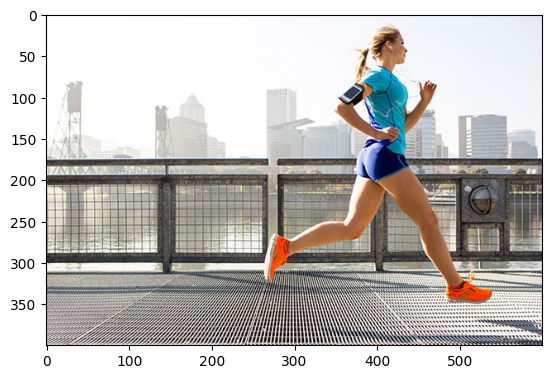

Caption: is is room color. surface covered surfaceies holding fancy the girl part tan holding cross fancy. staring people girl partly locker amidst mit fancy young his wearing playing


In [23]:
import matplotlib.pyplot as plt

def load_checkpoint(encoder, decoder, filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    encoder.load_state_dict(checkpoint['encoder_state_dict'], strict=False)
    decoder.load_state_dict(checkpoint['decoder_state_dict'], strict=False)

    encoder.eval()
    decoder.eval()


def init_model(checkpoint_path=None):
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    viT_pretrained_model = 'google/vit-base-patch16-224'
    max_length = 40
    encoder_dim = 768
    decoder_dim = 512
    bert_model_name = 'bert-base-cased'
    d_model = 512
    nhead = 8
    num_layers = 6
    n_vocab = 28996
    batch_size = 1


    encoder = ImageEncoder(device, viT_pretrained_model).to(device)
    decoder = ImageCaptionDecoder(device, encoder_dim, decoder_dim, bert_model_name, d_model, nhead, num_layers, batch_size, n_vocab).to(device)

    if checkpoint_path is not None:
        load_checkpoint(encoder, decoder, checkpoint_path)

    # # Warm-up run
    # with torch.no_grad():
    #     dummy_input_ids = torch.zeros((1, 1), dtype=torch.long)
    #     dummy_attention_mask = torch.ones((1, 1), dtype=torch.long)
    #     dummy_image = torch.zeros((1, 3, 224, 224))

    #     if checkpoint_path is not None:
    #         dummy_image = dummy_image.to(encoder.device)
    #         dummy_input_ids = dummy_input_ids.to(encoder.device)
    #         dummy_attention_mask = dummy_attention_mask.to(encoder.device)

    #     _ = encoder(dummy_image)
    #     _ = decoder(dummy_image, dummy_input_ids, dummy_attention_mask)

    return encoder, decoder, tokenizer, max_length, batch_size


def demo(image_path, encoder, decoder, tokenizer, max_length, batch_size):
    # Set the models to evaluation mode
    encoder.eval()
    decoder.eval()

    image_tensor = process_image(image_path)

    # Move the image tensor to the same device that the models are on
    image_tensor = image_tensor.to(encoder.device)

    # Encode the image
    encoded_image = encoder(image_tensor)

    # Prepare the input to the decoder
    input_ids = torch.tensor(tokenizer.encode(["[CLS]"])).unsqueeze(0).to(encoder.device)
    attention_mask = torch.ones(input_ids.shape).to(encoder.device)

    # Initiate caption
    caption = []

    for _ in range(max_length):
        decoder_output = decoder(encoded_image, input_ids, attention_mask)
        predictions = decoder_output
        predicted_id = torch.argmax(predictions[:, -1, :]).item()
        if predicted_id == tokenizer.encode(["[SEP]"])[0] or len(caption)>= max_length:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_id]]).to(encoder.device)], dim=-1)
        attention_mask = torch.cat([attention_mask, torch.tensor([[1]]).to(encoder.device)], dim=-1)
        caption.append(predicted_id)
        # caption += tokenizer.decode([predicted_id])

    caption = tokenizer.decode(caption, skip_special_tokens=True)
    caption = caption.replace("[CLS]", "").replace("[SEP]", "")
    return caption.strip()


checkpoint_path = "checkpoint.pt"
img_file = "image.jpg"

encoder, decoder, tokenizer, max_length, batch_size = init_model(checkpoint_path)
caption = demo(img_file, encoder, decoder, tokenizer, max_length, batch_size)

image = Image.open(img_file)
plt.imshow(image)

plt.show()
print('Caption:', caption)
